## Cluster 1에서의 세부 클러스터링

In [ ]:
df_cluster_1 = df_cleaned[df_cleaned['클러스터_PCA_3'] == 1].copy()

X_1 = df_cluster_1[cols_to_use]

# 표준화
scaler = StandardScaler()
X_1_scaled = scaler.fit_transform(X_1)

pca = PCA(n_components=2)
X_1_pca = pca.fit_transform(X_1_scaled)

ssd = []
silhouette_scores = {}

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_1_pca)

    ssd.append(kmeans.inertia_)
    sil_score = silhouette_score(X_1_pca, labels)
    silhouette_scores[k] = sil_score

    df_cluster_1[f'하위클러스터_{k}'] = labels

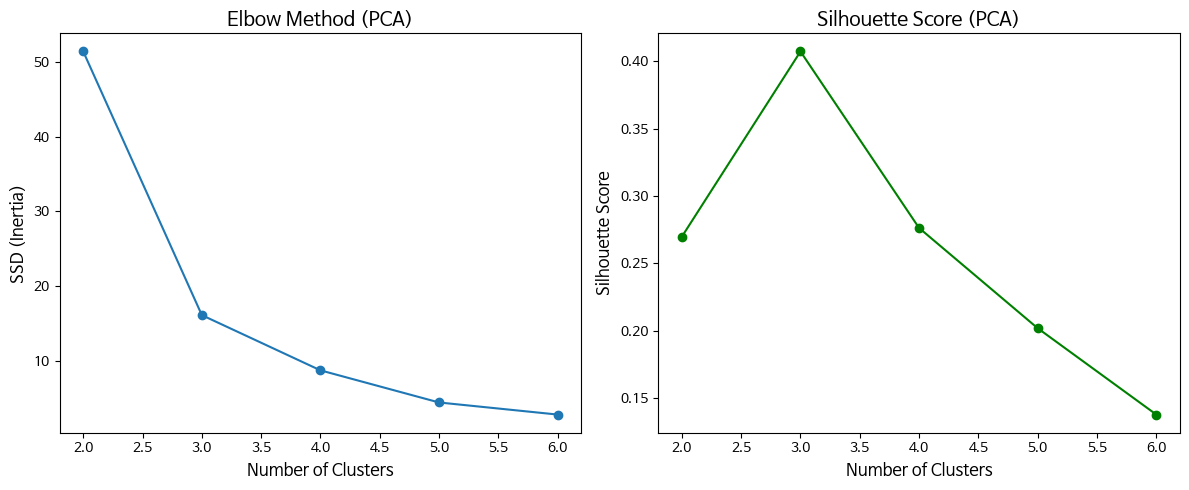

In [ ]:
plt.figure(figsize=(12, 5))

# Elbow
plt.subplot(1, 2, 1)
plt.plot(range(2, 7), ssd, 'o-')
plt.title('Elbow Method (PCA)', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('SSD (Inertia)', fontsize=12)

# Silhouette score
plt.subplot(1, 2, 2)
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'o-', color='green')
plt.title('Silhouette Score (PCA)', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
best_k_1 = max(silhouette_scores, key=silhouette_scores.get)
print(f" cluster 1의 최적 k: {best_k_1} (실루엣 계수: {silhouette_scores[best_k_1]:.3f})")

 cluster 1의 최적 k: 3 (실루엣 계수: 0.407)


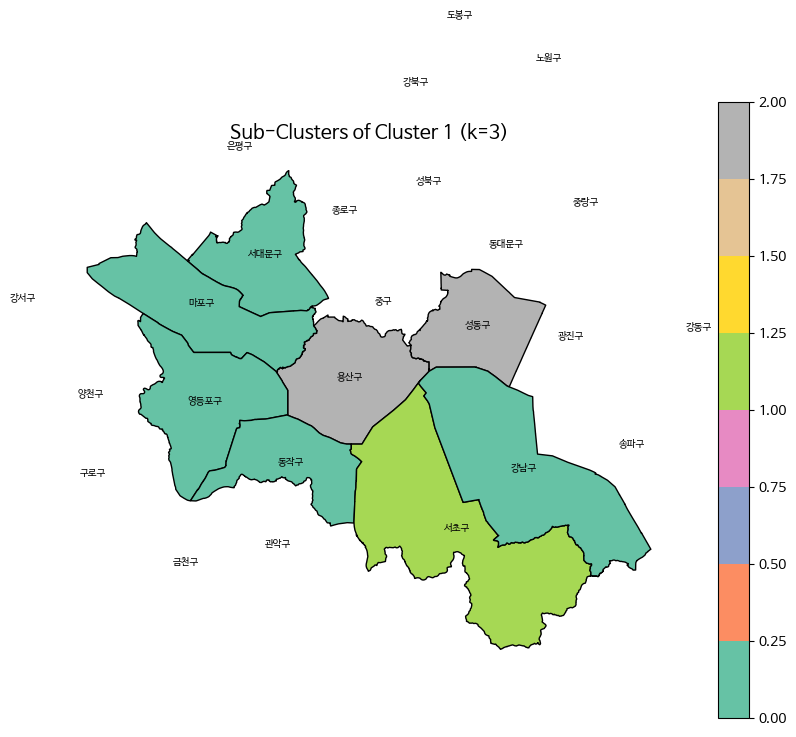

In [ ]:
shp_path = "/content/drive/MyDrive/코랩/데이터마이닝/팀플/data/LARD_ADM_SECT_SGG_11_202505.shp"
gdf = gpd.read_file(shp_path).rename(columns={"SGG_NM": "자치구"})
gdf["자치구"] = gdf["자치구"].apply(lambda x: x.replace("서울특별시", "").strip())
gdf = gdf.to_crs(epsg=4326)

# 병합 (자치구 이름으로)
merged_1 = gdf.merge(df_cluster_1[['자치구', f'하위클러스터_{best_k_1}']], on='자치구', how='left')

# 지도 시각화
fig, ax = plt.subplots(figsize=(10, 8))
merged_1.plot(column=f'하위클러스터_{best_k_1}', cmap='Set2', legend=True, edgecolor='black', ax=ax)
ax.set_title(f"Sub-Clusters of Cluster 1 (k={best_k_1})", fontsize=14)

# 한글 자치구 이름 표기
for idx, row in merged_1.iterrows():
    if pd.notnull(row['자치구']):
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, row['자치구'], ha='center', fontsize=7, color='black')

# 축 제거
ax.axis("off")
plt.show()


In [ ]:
# 최적의 k (예: 실루엣 계수가 가장 높은 k=3 선택)
best_k_1 = 3

# 선택된 서브 클러스터 열 이름
subcluster_col = f'하위클러스터_{best_k_1}'

# 서브 클러스터별 주요 변수 평균값 계산
subcluster_summary = df_cluster_1.groupby(subcluster_col)[cols_to_use].mean().round(3)

print(" Cluster 1의 서브 클러스터별 평균값:")
subcluster_summary

 Cluster 1의 서브 클러스터별 평균값:


,추정 노인 자살률,경로당 수,요양보호사 수,평균노선수,노인 보행 교통사고,노인인구 수,1인당 독거노인 합계,1인당 기초수급자 합계,1인당 저소득노인 합계,1인당 노인의료복지시설 수,1인당 재가노인복지시설 수,1인당 복지관 수,1인당 복지관종사자 수,1인당 노인교실 수,1인당 정류장수
하위클러스터_3,,,,,,,,,,,,,,,
0,31.469,151.2,14261.0,3.836,71.2,68119.4,0.240,0.051,0.007,0.0,0.001,0.0,0.001,0.0,0.008
1,24.836,139.0,9663.0,4.085,52.0,65661.0,0.167,0.036,0.003,0.0,0.001,0.0,0.002,0.0,0.010
2,33.313,126.5,8084.0,2.584,41.5,44604.5,0.255,0.074,0.004,0.0,0.001,0.0,0.002,0.0,0.009


 차이가 큰 변수들: ['경로당 수', '요양보호사 수', '노인 보행 교통사고', '노인인구 수']


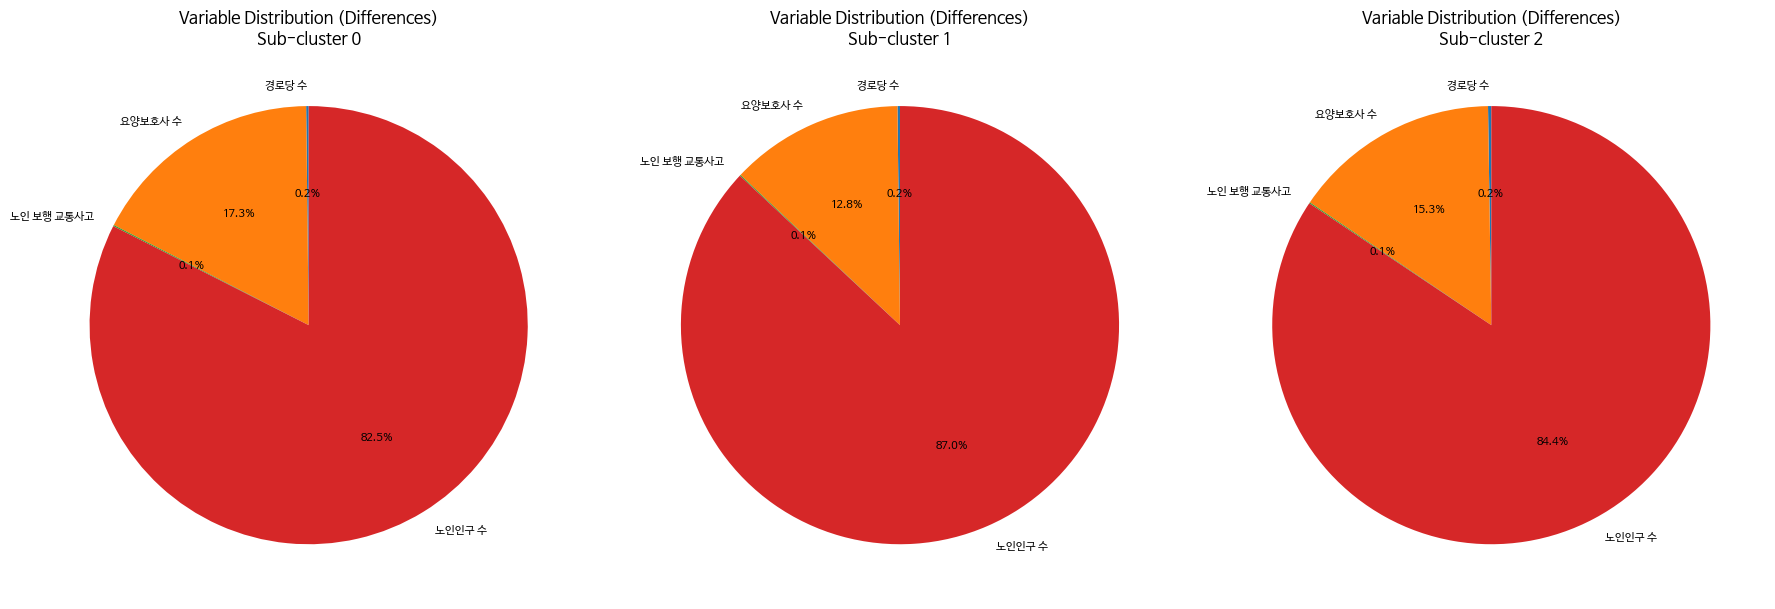

In [ ]:
# 변수별 최대-최소 차이 계산
diff = subcluster_summary.max() - subcluster_summary.min()

# 차이가 큰 변수만 선택 (예: 10 이상 차이)
important_vars = diff[diff > 10].index.tolist()
print(" 차이가 큰 변수들:", important_vars)

# 파이차트 시각화
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for idx, cluster_label in enumerate(subcluster_summary.index):
    axs[idx].pie(subcluster_summary.loc[cluster_label, important_vars],
                  labels=important_vars,
                  autopct='%1.1f%%',
                  startangle=90,
                  textprops={'fontsize': 8})
    axs[idx].set_title(f'Variable Distribution (Differences)\nSub-cluster {cluster_label}', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# 서브 클러스터가 저장된 컬럼 이름
subcluster_col = '하위클러스터_3'

# 서브 클러스터별 자치구 이름 출력
for cluster_label in df_cluster_1[subcluster_col].unique():
    gu_list = df_cluster_1[df_cluster_1[subcluster_col] == cluster_label]['자치구'].tolist()
    print(f" Sub-cluster {cluster_label}에 속하는 자치구:")
    print(gu_list)
    print()

 Sub-cluster 2에 속하는 자치구:
['용산구', '성동구']

 Sub-cluster 0에 속하는 자치구:
['서대문구', '마포구', '영등포구', '동작구', '강남구']

 Sub-cluster 1에 속하는 자치구:
['서초구']



<Cluster 1을 k=3으로 다시 클러스터링한 sub-cluster 0,1,2에 대한 해석>

Sub-cluster 0 (서대문구, 마포구, 영등포구, 동작구, 강남구 ) : 노인 인구 비중 다소 적고 노인 보행 교통사고 비중이 매우 작음. 경로당 수 거의 없음. 요양보호사 수 비교적 많아서 복지 서비스 제공 여건이 좋음 시사.

Sub-cluster 1 ( 서초구 ) : 노인인구 비중이 가장 높고 요양보호사 수 비중이 다소 낮음. 복지 취약 가능성 높음.

Sub-cluster 2 ( 용산구, 성동구 ) : 노인 인구는 많지만, 요양보호사 비중도 상대적으로 높음.